# Processing Sequences Using RNNs

In [1]:
import sklearn
import tensorflow as tf

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Need to use this version of Numpy due to compatability issues with TF
#!pip install numpy==1.19.5

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Helper Functions

We define some helper functions we will need for plotting.

In [2]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [3]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [4]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


# Basic RNNs

## Generate the Dataset

Generate a noisy sine-based time series.

In [5]:
np.random.seed(42)

In [6]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [7]:
batch_size = 10000
n_steps = 50

In [9]:
series = generate_time_series(batch_size, n_steps+1)
series

array([[[-0.2991397 ],
        [-0.36455187],
        [-0.48004606],
        ...,
        [ 0.22806805],
        [ 0.22077505],
        [ 0.33207247]],

       [[ 0.05033522],
        [ 0.09826873],
        [ 0.23941976],
        ...,
        [ 0.372363  ],
        [ 0.48769566],
        [ 0.52702606]],

       [[-0.14547299],
        [-0.05101485],
        [-0.00078506],
        ...,
        [-0.49106833],
        [-0.551142  ],
        [-0.6015384 ]],

       ...,

       [[-0.5900913 ],
        [-0.578741  ],
        [-0.43243292],
        ...,
        [-0.5701567 ],
        [-0.4314404 ],
        [-0.25422585]],

       [[ 0.5449028 ],
        [ 0.35739246],
        [ 0.11109259],
        ...,
        [-0.2863576 ],
        [-0.03930337],
        [ 0.1782258 ]],

       [[-0.3412474 ],
        [-0.11909661],
        [ 0.21660395],
        ...,
        [-0.5188141 ],
        [-0.31590286],
        [-0.09697805]]], dtype=float32)

We generate the time series data with training and test data. The X data consists of the first 50 time steps and the Y-data is the last data point.

In [9]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [10]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Let's check that this worked for a random series.

Plot the any of the series

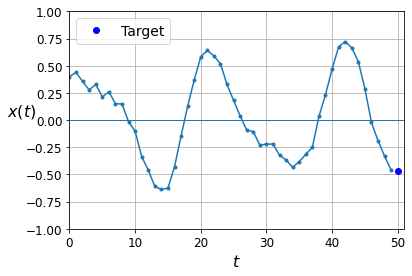

In [11]:
col = 1822
plot_series(X_train[col, :, 0], y_train[col, 0])
plt.show()

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions. 

## Computing Some Baselines

Naive predictions (just predict the last observed value):

In [12]:
from tensorflow import keras
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [13]:
i = 0

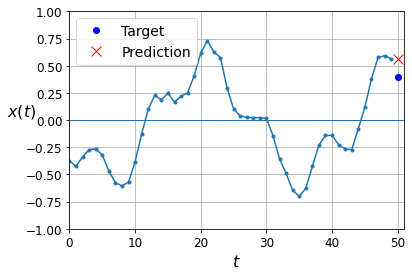

In [14]:
plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0])
plt.show()

This is about the best worst guess you can make.

## Basic Feedforward Network

Let's train a simple network with two layers of 50 neurons to predict.

In [15]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(50),
    keras.layers.Dense(50),
    keras.layers.Dense(1)
])
model.summary()
model.compile(loss="mse", optimizer="adam")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,151
Trainable params: 5,151
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.0205 - val_loss: 0.0044
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0035

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0031


0.0030636596493422985

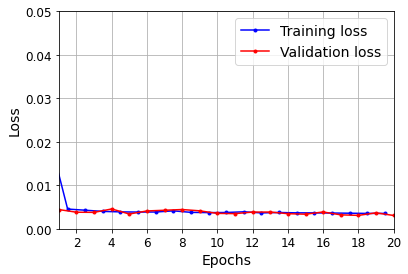

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

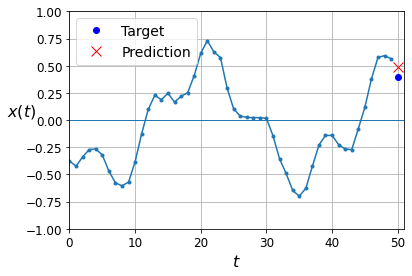

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

This looks OK.

## Deep RNNs

We are still just predicting one period ahead. 

Make the SimpleRNN layer return only the last output:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, 
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss="mse", optimizer="adam")

In [23]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 28ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0030 - val_lo

In [24]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0026


0.0026236227713525295

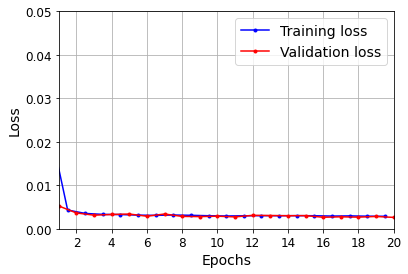

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

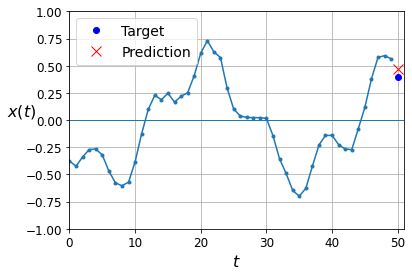

In [26]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Looks good!

## One-Period Model Forecasting Several Steps Ahead

We generate a single series with 10 extra points.

In [27]:
# we generate a time series - to be out of sample we set the seed to 
# 43 as using 42 would give the first series in the train set

np.random.seed(43) 

Use SimpleRNN to predict each next value and to then use the prediction to predict the next value.

In [28]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [29]:
Y_pred.shape

(1, 10, 1)

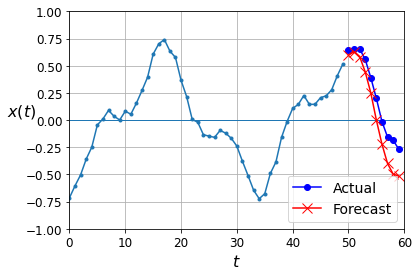

In [30]:

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Build a Deep RNN to Predict 10 Periods ahead.

Now let's build a new Deep RNN model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [31]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's create an RNN that predicts all 10 next values at once:

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, 
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss="mse", optimizer="adam")

In [35]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 27ms/step - loss: 0.0502 - val_loss: 0.0265
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0204 - val_loss: 0.0192
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0151 - val_loss: 0.0137
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0123 - val_loss: 0.0106
Epoch 7/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 8/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 9/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 10/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0105 - val_lo

In [36]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

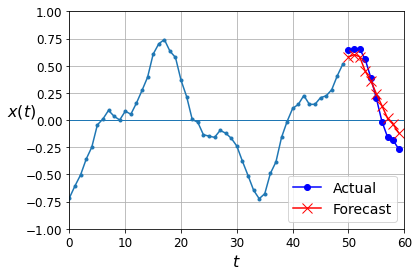

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## A Sequence to Sequence Model

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

We need to reorganise the input data to make this possible.

In [38]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [39]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [40]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              metrics=[last_time_step_mse])

In [43]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3979s 18s/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0367 - val_last_time_step_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0324 - last_time_step_mse: 0.0213 - val_loss: 0.0302 - val_last_time_step_mse: 0.0192
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0299 - last_time_step_mse: 0.0188 - val_loss: 0.0272 - val_last_time_step_mse: 0.0154
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0274 - last_time_step_mse: 0.0155 - val_loss: 0.0262 - val_last_time_step_mse: 0.0142
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0248 - last_time_step_mse: 0.0121 - val_loss: 0.0216 - val_last_time_step_mse: 0.0082
Epoch 7/20
219/219 [

In [44]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0195 - last_time_step_mse: 0.0085


[0.019529441371560097, 0.008523741737008095]

In [45]:
# Generate an out of sample path
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

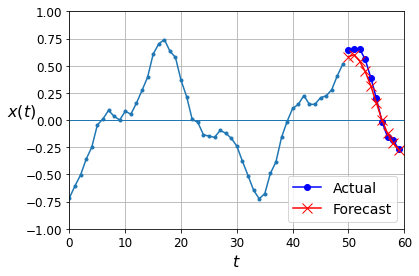

In [46]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTMs

Let's repeat this with an LSTM

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [48]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [49]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 24s 65ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/2

In [50]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788679391145706, 0.008560794405639172]

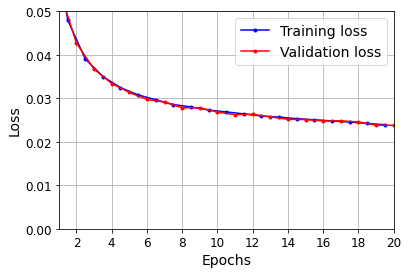

In [51]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

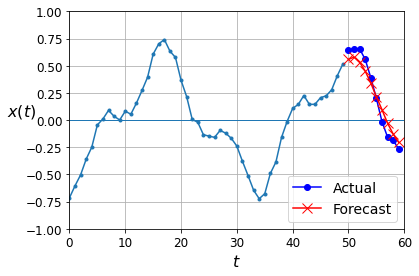

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [55]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [56]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 42ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [

In [57]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 15ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262805968523026]

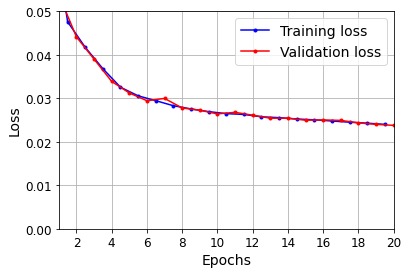

In [58]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [59]:
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

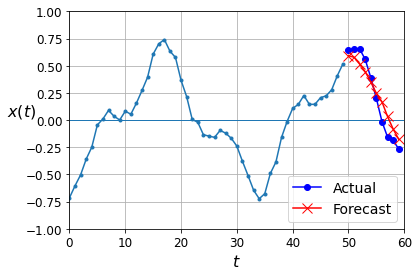

In [60]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Adding a Special Layer !!

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, 
                        padding="valid", input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [63]:
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 16s 48ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=

In [64]:
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 [==============================] - 0s 6ms/step - loss: 0.0184 - last_time_step_mse: 0.0080


[0.018366213887929916, 0.007968203164637089]

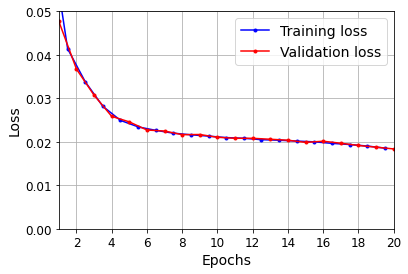

In [65]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [66]:
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

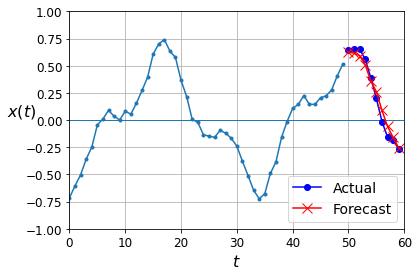

In [67]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

This is the best model so far. You will do CNNs next week !